# Carcass detection using Canny contours

### Projet 5BIM L.Matsuda, D.Mikec, R.Thiebaut

I filtered images based on 3 criteria:
 1. Presence of Canny contours
 2. Presence of white (bright) pixels
 3. Number of white (bright) pixels
 

Import libraries:

In [8]:
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal

File paths (imagettes/ contains all 480x480 images)

Analysis are done on gray scale images

In [9]:
annotated_img = '../Selection_imagettes/'
all_img = 'imagettes/'

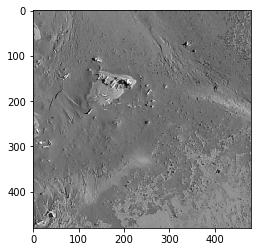

In [14]:
#example of carcass
img = cv2.imread(annotated_img + 'Carcasse/181_35.png',0)
plt.imshow(img,cmap = 'gray')

## 1. Canny contours

You need to input 2 thresholds to use the Canny algorithm.
Edges with values below the lower threshold are discarded.
Edges with some values between the 2 thresholds and some above the higher threshold are kept.
https://docs.opencv.org/master/da/d22/tutorial_py_canny.html

Thresholds are very important.
The optimal thresholds will depend on the image. There are methods such as Otsu to automatically find thresholds. However it gives thresholds way too low in this case.

In [15]:
high_thresh, thresh_im = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
high_thresh

128.0

Canny is also very suceptible to noise. Cassically you would want to smooth the image by using a gaussian filter for example.
But here objects we want to detect are rather small so applying a gaussian blur could be dangerous.

Canny might not be the right approach to begin with, but it still gives decent results with certain parameters. 

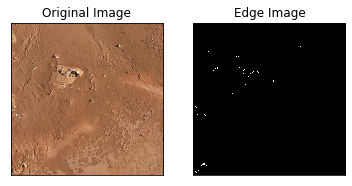

In [16]:
img = cv2.imread('../Selection_imagettes/Carcasse/181_35.png',0)
bgr = cv2.imread('../Selection_imagettes/Carcasse/181_35.png')
edges = cv2.Canny(img,400,600)

plt.subplot(121),plt.imshow(cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB),cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])

plt.show()

I ended up using 400 and 600 as thresholds based on various tests.
I wanted to limit as much as possible detection of unwanted features, while keeping carcasse.
This of course should be adapted to each dataset and objects we want to detect.

In [17]:
carcasse = os.listdir('../Selection_imagettes/Carcasse/')

In [18]:
def canny_edges(path):
    dico = {}
    files = os.listdir(path)
    for file in files:
        img = cv2.imread(path + file,0) #load the image  
        edges = cv2.Canny(img,400,600) #edge detection
        dico[file] =  np.sum(edges)/255 #store number of edge points inside dict

    return dico

In [19]:
edges = canny_edges('imagettes/')
#np.save('canny_edges.npy', edges)
#edges = np.load('canny_edges.npy',allow_pickle='TRUE').item()

## 2. White pixels

### 2.1. Max intensity

One thing that distinguishes well carcass is the presence of white pixels.
For each image we looked for the maximum intensity which will be close to 255, in case the image contains white pixels.

This was a rather simple method but worked pretty well under this dataset.

In [20]:
files = os.listdir(all_img)

max_pixel = {}
for file in files:
    img = cv2.imread(all_img + file,0)
    max_pixel[file] = np.max(img) #store in dict the intensity max value 
    
#to save and load dict
#np.save('max_pixel.npy', max_pixel) 
#max_pixel = np.load('max_pixel.npy',allow_pickle='TRUE').item()

In [22]:
pixel210 = {}
for file in files:
    img = cv2.imread(all_img + file,0)
    pixel210[file] = np.sum(img >210) #number of pixels higher than 210
    
#to save and load dict
#np.save('pixel210.npy', pixel210) 
#pixel210 = np.load('pixel210.npy',allow_pickle='TRUE').item()


In [23]:
#selecting images containing pixels higher than 240
white = []
for i in max_pixel.keys():
    if max_pixel[i] > 240:
        white.append(i)

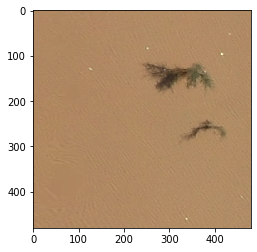

In [25]:
#example of false positive
img = cv2.imread(all_img + white[13])
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

The image above contains white pixels but does not contain enough contours. Combining both filters it will be discarded.

### 2.1. Number of white pixels

We can also filter on the number of pixels.
We can set a maximum for white pixels so that we do not detect objects like cars.
Carcass usually will not have as many white pixels.

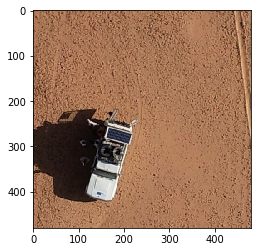

In [26]:
img = cv2.imread('imagettes/179_56.png')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [28]:
pixel210['179_56.png']

2346

I also tried a method that detects images where contours are around white pixels.
Results are however not much better.

In [29]:
def prod(path,files):
    dico = {}
    kernel = np.ones((15,15), dtype=int) #15x15 matrix of ones
    
    for file in files:
        img = cv2.imread(path + file,0)
        
        edges = cv2.Canny(img,400,600)
        img200 = img  >210 # binary matrix :1 if the px is >210, else 0
        img200 = signal.convolve2d(img200, kernel, mode="same") #convolution : px in the 15x15 neighborhood of >210 px are given 1
        prod = img200* edges #If the edge is near a >210 px, it is kept
        
        dico[file] =  np.sum(prod)/255

    return dico

In [30]:
#dico = prod('imagettes/',files)

## 3. Final results

In [34]:
white_canny = []
for key in files:
    if edges[key] >50 and max_pixel[key] > 240 and pixel210[key] < 1000:
        white_canny.append(key)

#we select images with more than 50 contour points, containing pixels higher than 240, and having less than 1000 white pixels

In [35]:
len(white_canny)

71

We detect 71 images with carcass from 14543 images.

In [36]:
len(set(carcasse) & set(white_canny))

44

44 out of 71 are correctly predicted.

Manually we found 76 images with carcass. So, 32 are not detected. However in some cases manual annotations could be wrong.

### Example of not detected images

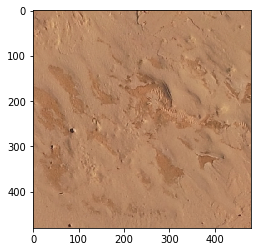

In [37]:
img = cv2.imread('imagettes/91_32.png')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

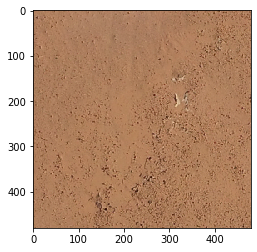

In [38]:
img = cv2.imread('imagettes/232_50.png')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [16]:
# to export results
#with open("white_canny.txt", "w") as output:
#    output.write(str(white_canny))